In [2]:
import os
import cv2 
import tifffile
import statistics
import numpy as np

from tqdm import tqdm
from glob import glob
from skimage.io import imsave, imread
from skimage import (
    measure,
    morphology,
    filters,
    exposure,
    feature,
    img_as_uint,
    img_as_ubyte,
)

from commons import (rescale_arr, 
                     check_colision_border, 
                     smoothing_mask_edges, 
                     find_bighest_cluster,
                     binarize_image,
                     auto_invert_image_mask,
                     fill_smoothing_mask_edges,
                     plot)

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
def adaptive_threshold(image):
    def apply_thresh(image, block_size=1, thresh_type=199):
        return cv2.adaptiveThreshold(image, 
                                     255,
                                     cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY_INV, 
                                     thresh_type,
                                     block_size).astype(bool)
    mask = apply_thresh(image)
    mask = auto_invert_image_mask(mask)
    
    if check_colision_border(mask):
        for block in range(1, 9):

            mask = apply_thresh(image, block)
            mask = find_bighest_cluster(mask)
            
            if not check_colision_border(mask): break

    mask = auto_invert_image_mask(mask)
    
    return fill_smoothing_mask_edges(mask)

In [54]:
def apply_segment_sobel_canny(img):
    
    """
        Eu dou preferência para o sobel, caso ele não tank eu vou de canny, até dá certo xD
    """
    image_eq = exposure.equalize_hist(img)
    
    sobel_mask = filters.sobel(image_eq)
    sobel_mask = fill_smoothing_mask_edges(sobel_mask)
    
    if not check_colision_border(sobel_mask):
        return sobel_mask

    for sigma in range(0, 9):

        canny_mask = feature.canny(image_eq, sigma=sigma)
        canny_mask = fill_smoothing_mask_edges(canny_mask)

        if not check_colision_border(canny_mask): 
            break

    return canny_mask

In [111]:
def smoothing_mask_edges(mask):
    return binarize_image(filters.gaussian(mask, sigma=0.5))

def fill_smoothing_mask_edges(mask):
    
    from scipy import ndimage as ndi

    mask = binarize_image(mask)

    mask = morphology.closing(mask, morphology.disk(2))

    mask = ndi.binary_fill_holes(mask)

    mask = filters.gaussian(mask, sigma=0.1)
    
    return find_bighest_cluster(mask)

## Exemplo dos segmenters

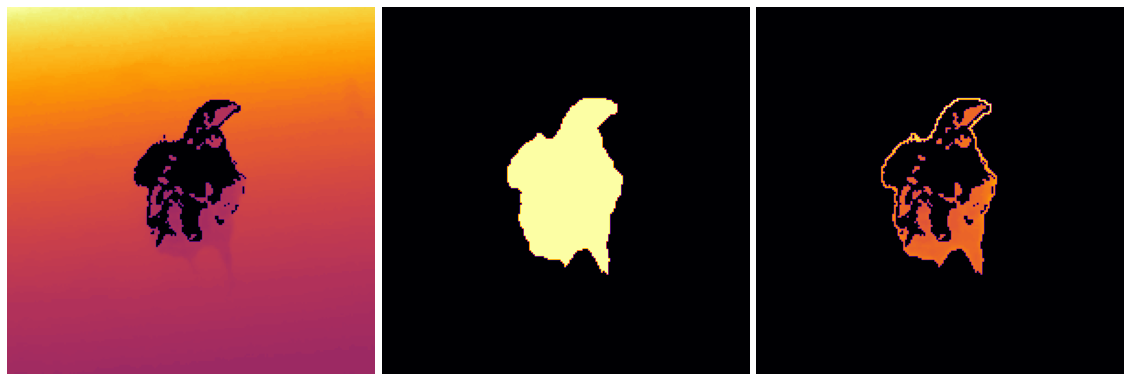

In [112]:
image = imread('it_has_to_work/segmentadas/images/002.tif')

mask_sobel_canny = apply_segment_sobel_canny(image)
plot([image, mask_sobel_canny, (image * mask_sobel_canny)], (1, 3))

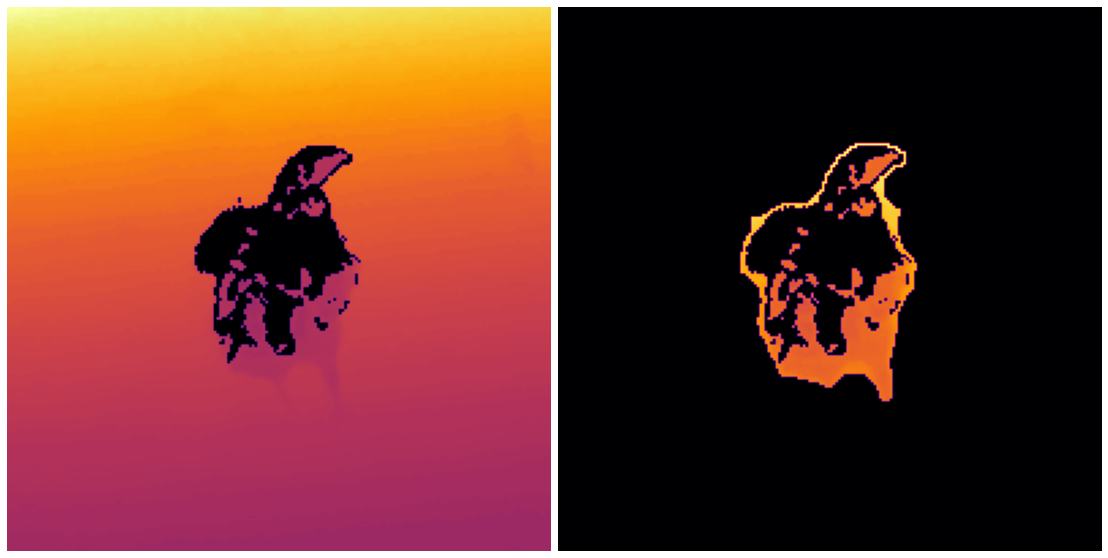

In [18]:
mask_adpt_thresh = adaptive_threshold(image)
plot([image, (image * mask_adpt_thresh)], (1, 2))

## Rodando na base completa

In [ ]:
def run_segmenter(function_run, from_images, destiny_images):
    
    try:
        os.makedirs(destiny_images)
    except Exception:
        pass

    for path in tqdm(glob(f'{from_images}/*')):

        image_name = path.split('/')[2]

        try:
            os.makedirs(f'{destiny_images}/{image_name}')
        except Exception as e:
            pass

        for path_frames in glob(path + '/*'):

            image_frame_name,_ = path_frames.split('/')[3].split('.')

            try:

                frame = imread(path_frames)

                mask = function_run(frame).astype(bool)

                imsave(f'{destiny_images}/{image_name}/{image_frame_name}.tif', img_as_ubyte(mask))

            except Exception as e:
                continue

In [ ]:
run_segmenter(function_run=adaptive_threshold,
              destiny_images='adaptive_threshold',
              from_images='segmenter_v2/images')

In [ ]:
run_segmenter(function_run=adaptive_threshold,
              destiny_images='sobel_canny',
              from_images='segmenter_v2/images')